In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Baby Equation

# $$ \frac{dx}{dt} = \lambda x$$

# Setup

### Generator takes input $t$ and proposes solutions: $x(t)$

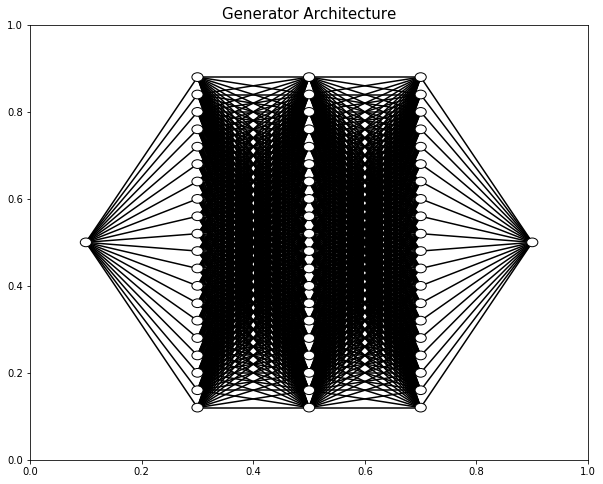

In [2]:
from denn.utils import draw_neural_net
fig, ax = plt.subplots(1,1,figsize=(10,8))
draw_neural_net(ax, .1, .9, .1, .9, [1,20, 20, 20,1])
ax.set_title('Generator Architecture', fontsize=15);

### Autograd used to calculate derivative $\frac{dx}{dt}$.

### Discriminator classifies real for $\lambda x$ and fake for $\frac{dx}{dt}$. Generator tries to fool discriminator to predict real on fake.

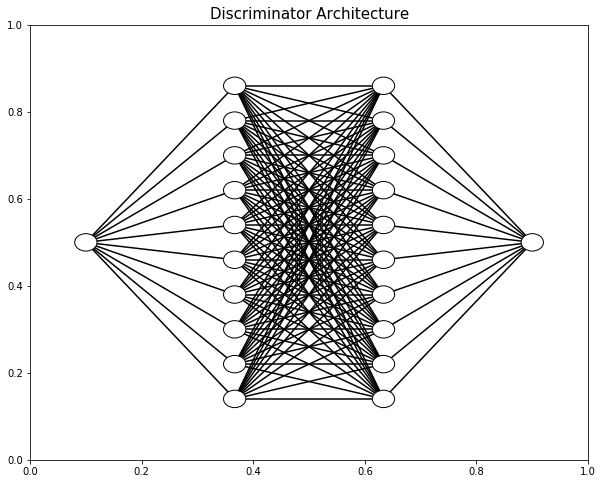

In [3]:
from denn.utils import draw_neural_net
fig, ax = plt.subplots(1,1,figsize=(10,8))
draw_neural_net(ax, .1, .9, .1, .9, [1, 10, 10,1])
ax.set_title('Discriminator Architecture', fontsize=15);

### They play this game until, hopefully, the generator produces solution x(t) indistinguishable from true.

![gan](../img/gan_diagram.png)

## Analytic Solutionn

In [2]:
L = -1
analytic = lambda t: np.exp(L*t)

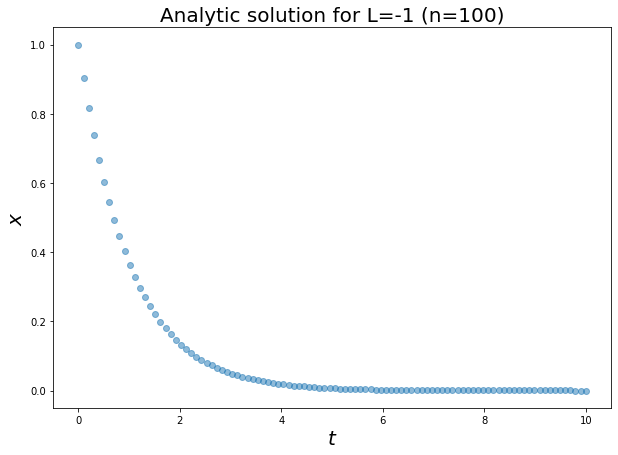

In [3]:
t = np.linspace(0,10,100)
plt.figure(figsize=(10,7))
plt.xlabel('$t$', fontsize=20)
plt.ylabel('$x$', fontsize=20)
plt.plot(t, analytic(t), 'o', alpha=0.5, label='analytic')
plt.title('Analytic solution for L=-1 (n=100)', fontsize=20);

## GAN

In [4]:
import torch
import torch.nn as nn
from torch import tensor, autograd
from collections import OrderedDict
torch.manual_seed(1337)

In [5]:
from denn.exp.gan_exp import Generator, Discriminator, train_GAN, train_Lagaris
from denn.exp.gan_exp import plot_loss, plot_preds, plot_losses_and_preds

## GAN Training

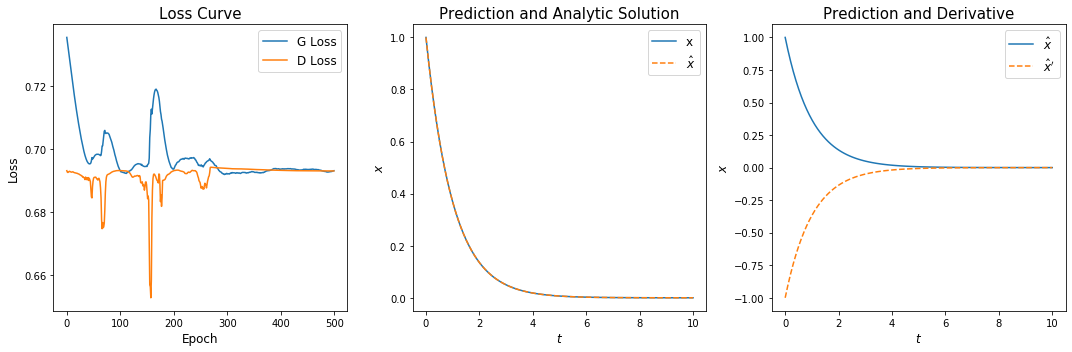

CPU times: user 39.7 s, sys: 253 ms, total: 40 s
Wall time: 40.1 s


(<matplotlib.axes._subplots.AxesSubplot at 0x1267faa58>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12689f2b0>)

In [6]:
%%time
G,D,G_loss,D_loss = train_GAN(500, 
                              g_hidden_units=20, 
                              g_hidden_layers=3,
                              d_hidden_units=10, 
                              d_hidden_layers=2,
                              logging=False, 
                              G_iters=9, 
                              D_iters=1, 
                              n=100,
                              seed=123456)
plot_losses_and_preds(G_loss, D_loss, G, t, analytic) # (with fix of freezing parameters!)

## Lagaris Training

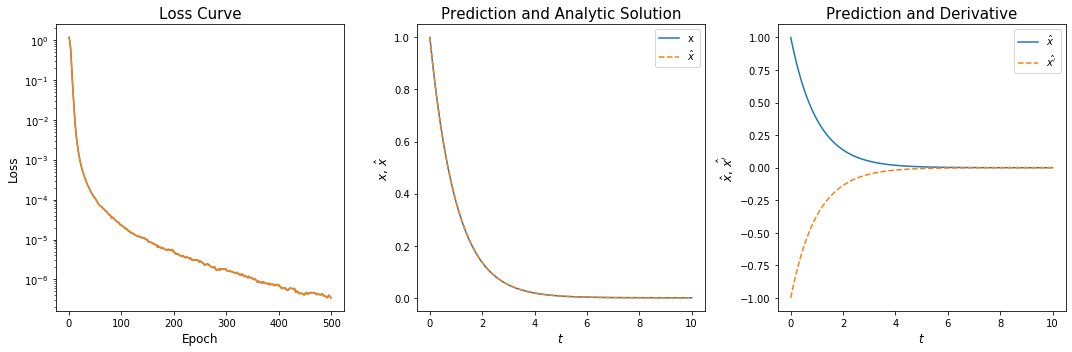

CPU times: user 36.9 s, sys: 226 ms, total: 37.2 s
Wall time: 37.3 s


In [10]:
%%time
F,F_loss = train_Lagaris(500, 
                         g_hidden_units=20, 
                         g_hidden_layers=3,
                         G_iters=10,
                         n=100)
ax = plot_losses_and_preds(F_loss, F_loss, F, t, analytic, legend=False)

## Compare MSE (pred vs. actual)

In [11]:
t_torch = tensor(t, dtype=torch.float, requires_grad=True).reshape(-1,1)
gan_pred = G.predict(t_torch)
lag_pred = F.predict(t_torch)

In [12]:
actual = tensor(analytic(t), dtype=torch.float).reshape(-1,1)

In [13]:
mse = nn.MSELoss()
gan_mse = mse(gan_pred, actual)
lag_mse = mse(lag_pred, actual)

In [14]:
print('GAN MSE: {}'.format(gan_mse))
print('Lagaris MSE: {}'.format(lag_mse))

GAN MSE: 3.340052604675293
Lagaris MSE: 1.9196097866824857e-07


## Compare MSE (many trials)

In [15]:
n = 10
ep = 500
gan_mses = []
lag_mses = []
lags = []
gans = []
F_losses = []
G_losses = []
D_losses = []
for i in range(n):
    
    G,D,G_loss,D_loss = train_GAN(ep, 
                              g_hidden_units=20, 
                              g_hidden_layers=3,
                              d_hidden_units=10, 
                              d_hidden_layers=2,
                              logging=False, 
                              G_iters=9, 
                              D_iters=1, 
                              n=100,
                              seed=None)
    
    F,F_loss = train_Lagaris(ep, 
                         g_hidden_units=20, 
                         g_hidden_layers=3,
                         G_iters=10,
                         n=100)
    
    gans.append(G)
    lags.append(F)
    
    gan_mses.append(mse(G.predict(t_torch), actual).item())
    lag_mses.append(mse(F.predict(t_torch), actual).item())
    
    G_losses.append(G_loss)
    D_losses.append(D_loss)
    F_losses.append(F_loss)

In [16]:
for i in range(n):
    spaces = ' '*(25-len(str(gan_mses[i])))
    print("GAN: {} {} LAG: {}".format(gan_mses[i], spaces, lag_mses[i]))

GAN: 3.3771770000457764         LAG: 8.048211541655803e-10
GAN: 3.0941515346180593e-16     LAG: 3.4133368131961106e-08
GAN: 6.767811866481566e-10      LAG: 7.470982410495708e-08
GAN: 3.0941515346180593e-16     LAG: 1.4247063084837919e-08
GAN: 2.298934874999975e-15      LAG: 1.3897553108321858e-09
GAN: 2.0488829139157436e-14     LAG: 8.999657019614915e-09
GAN: 7.214630233292815e-14      LAG: 2.219220007759759e-08
GAN: 4.3950358523186465e-15     LAG: 2.7645114641927648e-08
GAN: 3.951903908283594e-12      LAG: 5.383780177226072e-08
GAN: 3.0941515346180593e-16     LAG: 3.3254504927526796e-08


Text(0, 0.5, 'Mean Square Error')

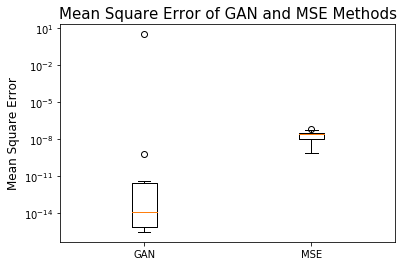

In [23]:
import seaborn as sns
fig, ax = plt.subplots(1,1)

ax.boxplot([gan_mses, lag_mses], labels=['GAN', 'MSE'])
ax.set_yscale('log')
ax.set_title('Mean Square Error of GAN and MSE Methods', fontsize=15)
ax.set_ylabel('Mean Square Error', fontsize=12)
# ax.hist(gan_mses, bins=10, label='GAN', scale='log')
# ax.hist(lag_mses, bins=10, label='Lagaris',  scale='log')
# ax.legend()
# ax.set_xlabel('log MSE')
# ax.set_ylabel('Frequency')
# ax.set_title('MSE Comparison of GAN vs Lagaris');


# sns.distplot(gan_mses, ax=ax)
# sns.distplot(lag_mses, ax=ax)

## Worst GAN

(<matplotlib.axes._subplots.AxesSubplot at 0x11771cda0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1176c4128>)

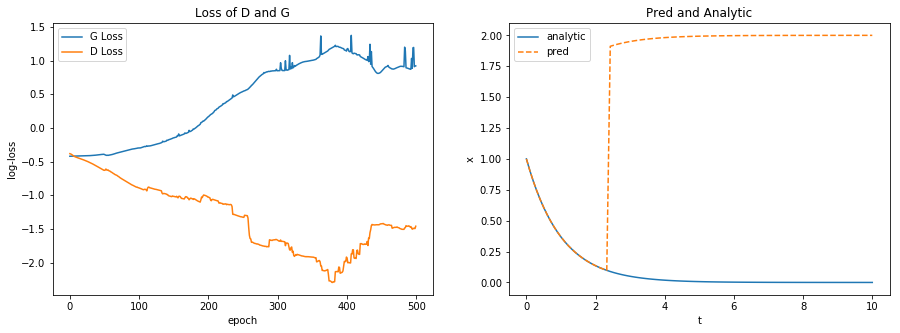

In [21]:
mess = np.argmax(gan_mses)
plot_losses_and_preds(G_losses[mess], D_losses[mess], gans[mess], t, analytic)

## Best GAN

(<matplotlib.axes._subplots.AxesSubplot at 0x105ed95c0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x105f03278>)

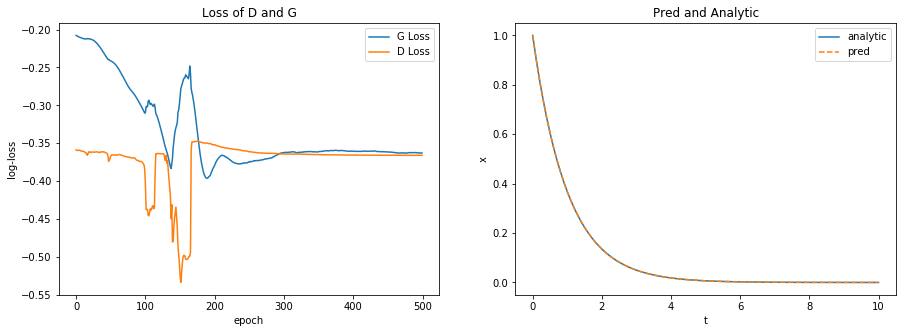

In [22]:
best = np.argmin(gan_mses)
plot_losses_and_preds(G_losses[best], D_losses[best], gans[best], t, analytic)

## All GAN Losses

In [23]:
join_losses = list(zip(G_losses, D_losses, gan_mses))
join_losses = sorted(join_losses, key=lambda x: x[2])

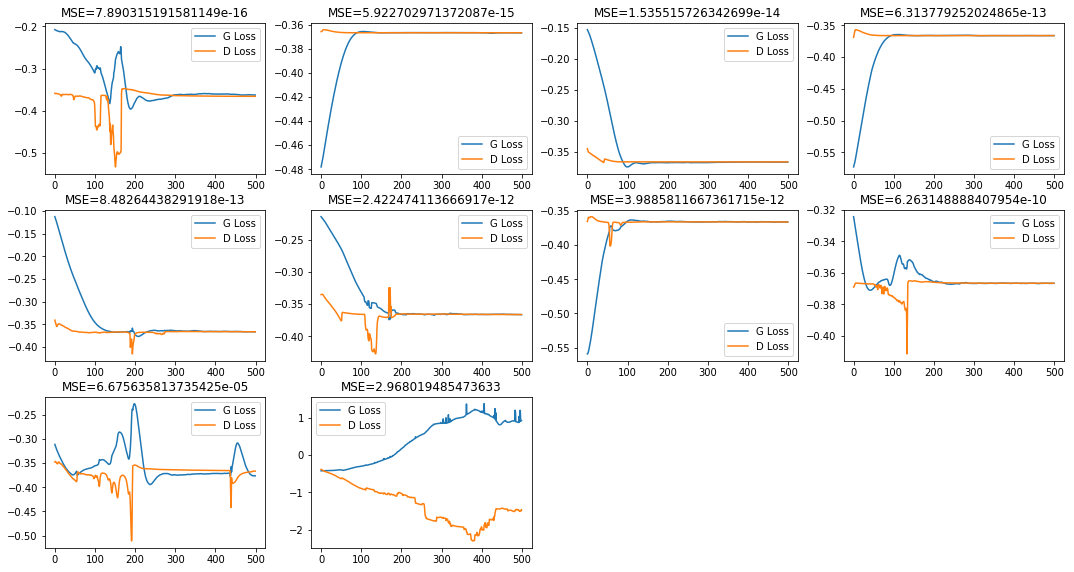

In [24]:
fig, ax = plt.subplots(3,4,figsize=(15,8))
fig.tight_layout(pad=1.5)
ax = ax.ravel()
for i, a_ in enumerate(ax):
    if i>len(G_losses)-1:
        fig.delaxes(a_)
    else:
        plot_loss(join_losses[i][0], join_losses[i][1], a_)
        a_.set_title("MSE={}".format(join_losses[i][2]))
        a_.set_xlabel('')
        a_.set_ylabel('')

## Extrapolate??

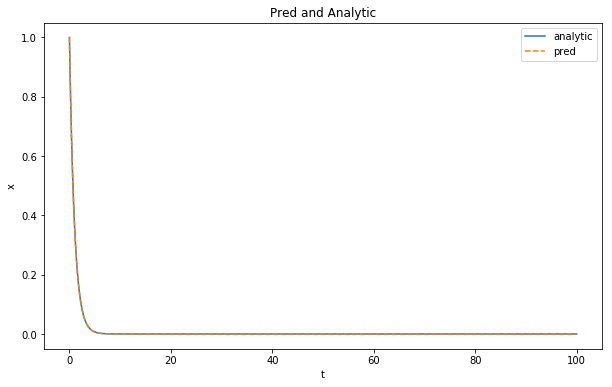

In [25]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
t_ext = np.linspace(0,100,1000)
plot_preds(gans[best], t_ext, analytic, ax)

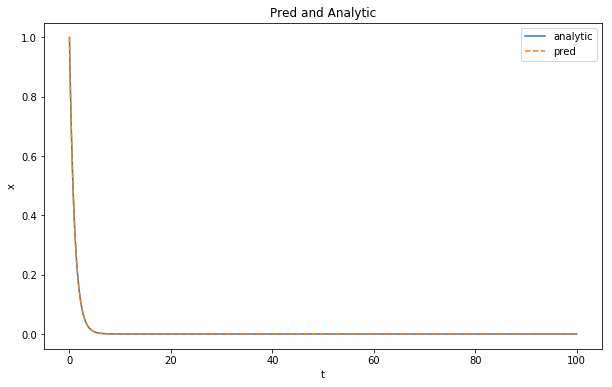

In [26]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
t_ext = np.linspace(0,100,1000)
plot_preds(lags[best], t_ext, analytic, ax)

Same as GAN in this case.

# New Equation: Simple Harmonic Oscillator

# $$ m \frac{d^2 x}{d t^2} = -kx $$

**Set up:**

## $ x = -\frac{m}{k} \frac{d^2 x}{d t^2} = -\frac{d^2 x}{d t^2} $

- Real: $x(t)$

- Fake: $-\frac{m}{k} \frac{d^2 x}{d t^2}$

- Constants: $m=1, k=1 \implies \omega = 1$

- Initial condition: $x(0) = 0, \frac{dx}{dt}(0)=-.5$ 

**Analytic Solution:**

$ x(t) = A \text{cos}(\omega t + \phi), \text{ where } \omega = \sqrt{\frac{k}{m}}$

or 

$ x(t) = x_0 \cos{\omega t} + \frac{v_0}{\omega} \sin(\omega t) $

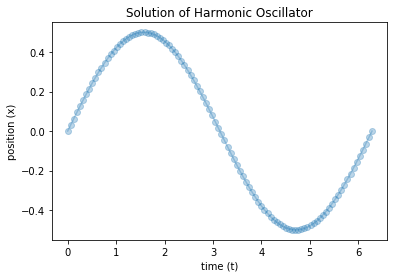

In [2]:
analytic_oscillator = lambda t: 0*np.cos(t) + .5*np.sin(t)
t = np.linspace(0,2*np.pi,100)
plt.plot(t, analytic_oscillator(t), '-o', alpha=0.3)
plt.title('Solution of Harmonic Oscillator')
plt.xlabel('time (t)')
plt.ylabel('position (x)');

** Note: ** it lies within the same range as `tanh` which is helpful.

In [1]:
from pde_nn.gan import train_GAN_SHO
import numpy as np
import torch.nn as nn
import torch

## Unsupervised

### Demo

In [13]:
# %%time
# torch.manual_seed(42)
# G,D,G_loss,D_loss = train_GAN_SHO(2000, 
#                               g_hidden_units=20, 
#                               g_hidden_layers=2,
#                               d_hidden_units=30, 
#                               d_hidden_layers=2,
#                               d_lr=0.001,
#                               g_lr=0.001,
#                               t_low=0,
#                               t_high=2*np.pi,
#                               logging=False,
#                               G_iters=9, 
#                               D_iters=1,
#                               n=100,
#                               x0=0.,
#                               dx_dt0=.5,
#                               realtime_plot=True,
#                               activation=nn.Tanh(),
#                               wgan=False,
#                               soft_labels=False,
#                               real_data=False)

- noise to x and derivative (independelty white nosie)
- two eqns (two generators?)

#### 15 Gen : 1 Disc | 20x2 Gen | 30x2 Disc

![best_unsup](pde_nn/pngsmanytoone/15Gto1D_6keps_20x2gen_30x2disc.png)

#### 9 Gen : 1 Disc | 20x2 Gen | 30x2 Disc

![2ndbest](pde_nn/pngs9to1/_BEST_9Gto1D_10keps_20x2gen_30x2disc.png)

## System of ODE

$$\begin{equation}
\frac{dx}{dt} = u
\end{equation}$$

$$\begin{equation}
\frac{du}{dt} = -x
\end{equation}$$

### Demo

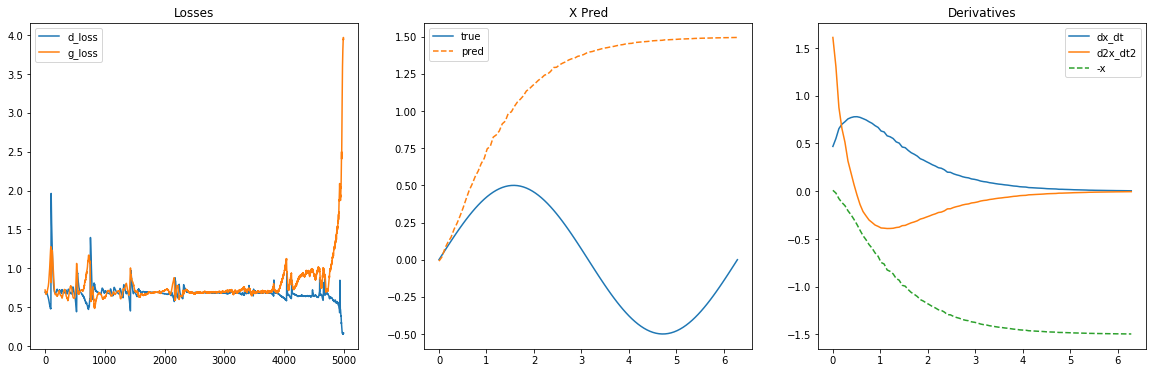

NameError: name 'D1' is not defined

In [2]:
%%time
torch.manual_seed(42)
G,D1,D2,G_loss,D_loss = train_GAN_SHO(5000, 
                              g_hidden_units=30, 
                              g_hidden_layers=3,
                              d_hidden_units=20, 
                              d_hidden_layers=2,
                              d_lr=0.001,
                              g_lr=0.001,
                              t_low=0,
                              t_high=2*np.pi,
                              logging=False,
                              G_iters=4,
                              D_iters=1,
                              n=100,
                              x0=0.,
                              gp_hyper=0.1,
                              dx_dt0=.5,
                              realtime_plot=True,
                              activation=nn.Tanh(),
                              wgan=False,
                              soft_labels=False,
                              real_data=False,
                              gradient_penalty=True,
                              systemOfODE=True)

#### 20x4 Gen | 2x 40x2 Disc | 4G : 1D **(System Non-Symplectic)**

![system](pde_nn/twodiscsystem/_twoDiscSystem_10keps_20x4gen_40x2disc_4Gto1D.png)

### Using data

In [14]:
# %%time
# G,D,G_loss,D_loss = train_GAN_SHO(5000, 
#                               g_hidden_units=20, 
#                               g_hidden_layers=2,
#                               d_hidden_units=30, 
#                               d_hidden_layers=2,
#                               d_lr=0.001,
#                               g_lr=0.001,
#                               t_low=0,
#                               t_high=2*np.pi,
#                               logging=False,
#                               G_iters=9, 
#                               D_iters=1,
#                               n=100,
#                               clip=.1,
#                               max_while=10,
#                               x0=0.,
#                               dx_dt0=.5,
#                               realtime_plot=True,
#                               activation=nn.Tanh(),
#                               wgan=False,
#                               soft_labels=False,
#                               real_data=True)

### WGAN

In [43]:
# %%time
# ## do it with data on (0,5) maybe
# G,D,G_loss,D_loss = train_GAN_SHO(2000, 
#                               g_hidden_units=20, 
#                               g_hidden_layers=1,
#                               d_hidden_units=60, 
#                               d_hidden_layers=1,
#                               d_lr=0.01,
#                               g_lr=0.01,
#                               t_low=0,
#                               t_high=1,
#                               logging=False,
#                               G_iters=1, 
#                               D_iters=1,
#                               n=100,
#                               clip=.1,
#                               max_while=10,
#                               x0=0,
#                               dx_dt0=-.5,
#                               realtime_plot=True,
#                               activation=nn.Tanh(),
#                               wgan=True,
#                               soft_labels=False,
#                               real_data=True,
#                               gradient_penalty=True,
#                               gp_hyper=1)

#### Literally fit the function?

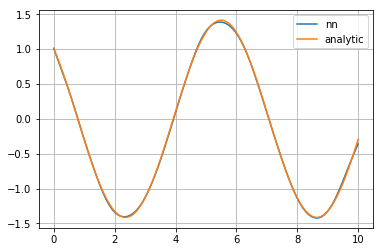

In [78]:
g=Generator(n_hidden_units=40, n_hidden_layers=4, activation=nn.Tanh(), output_tan=False)
t_torch = torch.tensor(t, dtype=torch.float).reshape(-1,1)
mse = torch.nn.MSELoss()
torch_analytical = 1*torch.cos(t_torch) + -1*torch.sin(t_torch)
opti_ = torch.optim.Adam(g.parameters(), lr=0.001, betas=(0.9, 0.999))

for e in range(1000):
    pred=g(t_torch)
    loss=mse(pred, torch_analytical)
    
    opti_.zero_grad()
    loss.backward()
    opti_.step()
    
plt.plot(t, g(t_torch).detach().numpy(), label='nn')
plt.plot(t, analytic_oscillator(t), label='analytic')
plt.legend()
plt.grid();

In [25]:
class Swish(torch.nn.Module):
    """
    Swish activation function
    """
    def __init__(self, beta=1.0):
        super(Swish, self).__init__()
        self.beta = beta

    def forward(self, input):
        return input * torch.sigmoid(self.beta * input)

    def extra_repr(self):
        return 'beta={}'.format(self.beta)

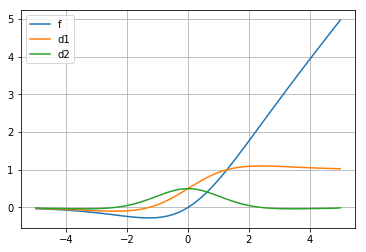

In [24]:
sigmoid = torch.nn.Sigmoid()
swish = lambda x: x * torch.sigmoid(1 * x)
x_in = torch.linspace(-5,5,100)
dx = x_in[1] - x_in[0]
swish_out = swish(x_in).detach().numpy()
x_in = x_in.detach().numpy()

plt.plot(x_in, swish_out, label='f')
swish_d1 = np.gradient(swish_out, x_in)
plt.plot(x_in, swish_d1, label='d1')
swish_d2 = np.gradient(swish_d1, x_in)
plt.plot(x_in, swish_d2, label='d2')
plt.legend()
plt.grid();

# Another Equation: Burgers' Equation

# $$ \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2} $$

**Set up:**

## $ u = \left( \nu \frac{\partial^2 u}{\partial x^2} - \frac{\partial u}{\partial t} \right) \left(\frac{\partial u}{\partial x}\right) ^{-1} $

- Real: $u(x,t)$

- Fake: $\left( \nu \frac{\partial^2 u}{\partial x^2} - \frac{\partial u}{\partial t} \right) \left(\frac{\partial u}{\partial x}\right) ^{-1}$

- Constant: $\nu = 1$

- Initial condition: $u(x,0)=f(x)$

**Numerical Solution:**
